# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- welcome: 8
- inform: 1
- multiple_choice: 6
- thanks: 7
- request: 0


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- taskcomplete: 16
- numberofkids: 15
- starttime: 20
- seating: 19
- description: 6


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 316: {'city': 'seattle', 'theater': 'regal meridian 16', 'other': 'name', 'starttime': '8:40', 'date': 'tonight', 'moviename': 'zootopia'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

grad_clip: -0.0001
dia_slot_val: 2
reg_cost: 0.001
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
save_check_point: 20
slot_rep: 1
max_epochs: 200
sdgtype: rmsprop
init_rnn: 0
cv_fold: 6
write_model_dir: .\checkpoints\template\07102016\
valid_test: 0
pretrained_model_path: None
check_point: 20
decay_rate: 0.999
feed_recurrence: 0
hidden_size: 100
activation_func: relu
momentum: 0.1
learning_rate: 0.001
batch_size: 16
act_set: data/dia_acts.txt
smooth_eps: 1e-08
split_method: 1
slot_set: data/slot_set.txt
eva_metric: 2
model: lstm_tanh
trained_model_path: None


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'city': 'birmingham', 'numberofpeople': '1', 'theater': 'carmike summit 16', 'state': 'al', 'starttime': 'around 2pm', 'date': 'today', 'moviename': 'zootopia'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- price: ['$20', '$10', 'cheapest', 'adult price is 8', '32']


###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [17]:

# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

agent_run_mode:3
16


# Dialog Manager
-------------------

In [18]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [20]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 120
# num_episodes = 60

In [21]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [22]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [23]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [25]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(100, status)

warm_start starting ...
Warm_Start 120 epochs, success rate 0.41, ave reward -7.2, ave turns 19.2
Current experience replay buffer size 960
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -55.44, ave turns 32.88
Train on : 2625
- cur bellman err 12.4669, experience replay pool 2625
=============== update_target_params ===============
Simulation success rate 0.0, Ave reward -55.44, Ave turns 32.88, Best success rate 0
Progress: 1 / 100, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -59.64, ave turns 41.28
Train on : 4689
- cur bellman err 8.4101, experience replay pool 4689
=============== update_target_params ===============
Simulation success rate 0.0, Ave reward -59.64, Ave turns 41.28, Best success rate 0
Progress: 2 / 100, Success rate: 0 / 2 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode:

- cur bellman err 7.5937, experience replay pool 43050
=============== update_target_params ===============
Simulation success rate 0.0, Ave reward -59.59, Ave turns 41.18, Best success rate 0
Progress: 21 / 100, Success rate: 0 / 21 Avg reward: -59.00 Avg turns: 40.00
----------------- Episode: 21 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 45150
- cur bellman err 9.1368, experience replay pool 45150
=============== update_target_params ===============
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 22 / 100, Success rate: 0 / 22 Avg reward: -59.05 Avg turns: 40.09
----------------- Episode: 22 ----------------- 
simulation success rate 0.0, ave reward -58.0, ave turns 38.0
Train on : 47050
- cur bellman err 11.2279, experience replay pool 47050
=============== update_target_params ===============
Simulation success rate 0.0, Ave reward -58.0, Ave turns 38.0, Best success rate 0
Progress: 23 /

- cur bellman err 6.2620, experience replay pool 3396
=============== update_target_params ===============
Simulation success rate 0.27, Ave reward -24.24, Ave turns 35.28, Best success rate 0
Progress: 40 / 100, Success rate: 4 / 40 Avg reward: -45.33 Avg turns: 36.65
----------------- Episode: 40 ----------------- 
simulation success rate 0.29, ave reward -20.77, ave turns 33.14
Train on : 5053
- cur bellman err 5.2926, experience replay pool 5053
=============== update_target_params ===============
Simulation success rate 0.29, Ave reward -20.77, Ave turns 33.14, Best success rate 0
Progress: 41 / 100, Success rate: 4 / 41 Avg reward: -45.68 Avg turns: 36.78
----------------- Episode: 41 ----------------- 
simulation success rate 0.31, ave reward -16.46, ave turns 29.32
simulation success rate 0.22, ave reward -27.83, ave turns 30.46
Train on : 1523
- cur bellman err 5.4863, experience replay pool 1523
=============== update_target_params ===============
Simulation success rate 0.31

Successful Dialog!
simulation success rate 0.5, ave reward 6.85, ave turns 28.3
simulation success rate 0.54, ave reward 12.79, ave turns 26.02
Train on : 1301
- cur bellman err 8.0272, experience replay pool 1301
=============== update_target_params ===============
Simulation success rate 0.5, Ave reward 6.85, Ave turns 28.3, Best success rate 0
Progress: 59 / 100, Success rate: 12 / 59 Avg reward: -31.54 Avg turns: 33.90
----------------- Episode: 59 ----------------- 
simulation success rate 0.46, ave reward 1.59, ave turns 29.22
simulation success rate 0.49, ave reward 5.77, ave turns 28.06
Train on : 1403
- cur bellman err 4.7345, experience replay pool 1403
=============== update_target_params ===============
Simulation success rate 0.46, Ave reward 1.59, Ave turns 29.22, Best success rate 0
Progress: 60 / 100, Success rate: 12 / 60 Avg reward: -31.85 Avg turns: 33.70
----------------- Episode: 60 ----------------- 
Successful Dialog!
simulation success rate 0.43, ave reward -2.4

simulation success rate 0.31, ave reward -18.96, ave turns 34.32
simulation success rate 0.28, ave reward -22.9, ave turns 35.0
Train on : 1750
- cur bellman err 6.5424, experience replay pool 1750
=============== update_target_params ===============
Simulation success rate 0.31, Ave reward -18.96, Ave turns 34.32, Best success rate 0
Progress: 77 / 100, Success rate: 18 / 77 Avg reward: -27.91 Avg turns: 33.92
----------------- Episode: 77 ----------------- 
simulation success rate 0.55, ave reward 13.61, ave turns 26.78
simulation success rate 0.46, ave reward 1.15, ave turns 30.1
Train on : 1505
- cur bellman err 4.9117, experience replay pool 1505
=============== update_target_params ===============
Simulation success rate 0.55, Ave reward 13.61, Ave turns 26.78, Best success rate 0
Progress: 78 / 100, Success rate: 18 / 78 Avg reward: -28.32 Avg turns: 34.03
----------------- Episode: 78 ----------------- 
simulation success rate 0.43, ave reward -1.64, ave turns 28.48
simulation 

simulation success rate 0.48, ave reward 3.77, ave turns 29.66
simulation success rate 0.57, ave reward 15.66, ave turns 27.48
Train on : 1374
- cur bellman err 5.5156, experience replay pool 1374
=============== update_target_params ===============
Simulation success rate 0.48, Ave reward 3.77, Ave turns 29.66, Best success rate 0
Progress: 95 / 100, Success rate: 28 / 95 Avg reward: -20.01 Avg turns: 32.76
----------------- Episode: 95 ----------------- 
simulation success rate 0.38, ave reward -9.58, ave turns 32.36
simulation success rate 0.49, ave reward 5.02, ave turns 29.56
Train on : 1478
- cur bellman err 4.5361, experience replay pool 1478
=============== update_target_params ===============
Simulation success rate 0.38, Ave reward -9.58, Ave turns 32.36, Best success rate 0
Progress: 96 / 100, Success rate: 28 / 96 Avg reward: -20.43 Avg turns: 32.85
----------------- Episode: 96 ----------------- 
simulation success rate 0.44, ave reward -1.91, ave turns 31.42
simulation su

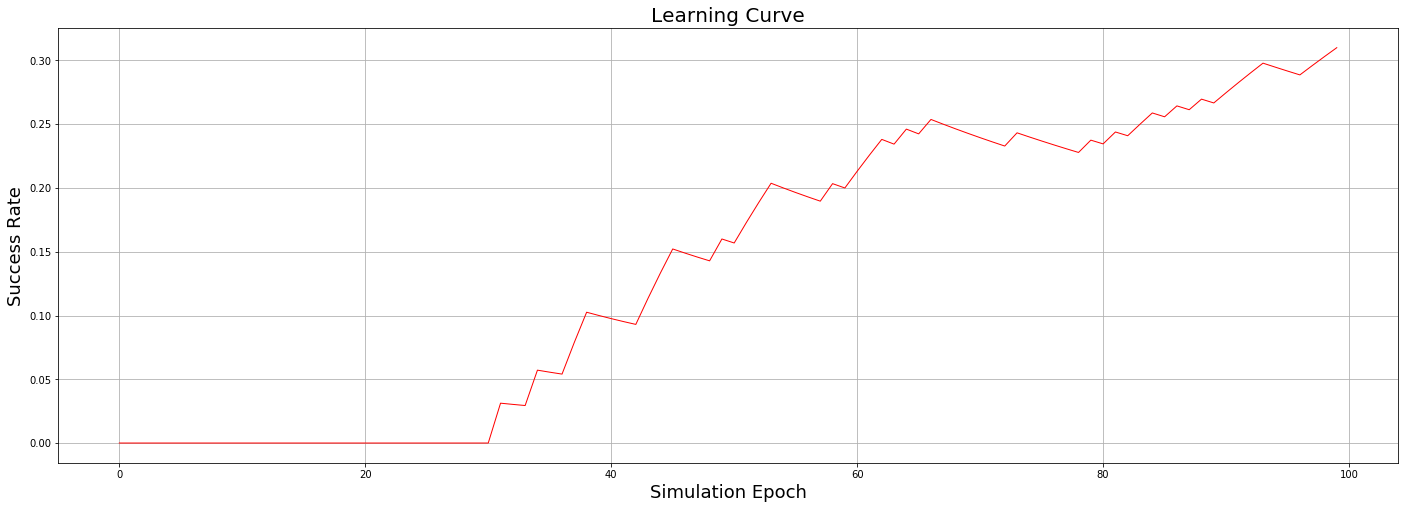

In [27]:
draw_learning_curve(curve)

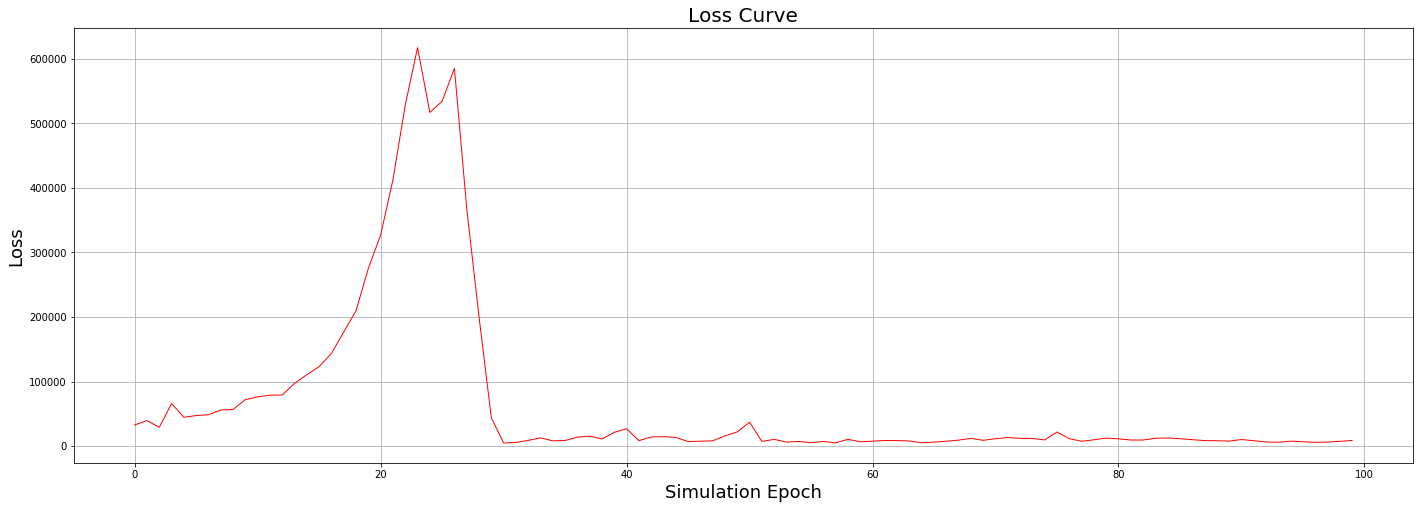

In [28]:
draw_loss_curve(losses)

In [ ]:
draw_loss_curve(losses[-100:])